# DISTRIBUITED ALGORITHMS - K-MEANS||

Alessio Tuscano - 1193922\
Chiara Tramarin - 1193231

Project for the Physics of Data course **Management and Analysis of Physics Dataset mod.B**, academic year 2023-2024.

## Goal
The goal of this project is to implement and benchmark the K-means|| algorithm across a distributed system using Dask. We will develop an alternative version of K-means||, aiming to identify the optimal cluster configuration that best utilizes the available resources. The performance will be assessed based on metrics such as execution time, memory usage, and the types of tasks performed. We will evaluate the algorithm's performance using the KDD Cup 1999 Data set (https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).

## Notebook organization

1) **Cluster set up**:\
1.1 Machines\
1.2 Configuration
3) **K-means||**:\
2.1 Scalable centroids initialization \
2.2 Scalable Lloyd's Algorithm\
2.3 KMeans technical walkthrough\
2.4 Test with synthetic dataset and comparison with Dask's k-means
5) **Dataset**:\
3.1 KDD Cup 1999 dataset\
3.2 K-means|| benchmarking on KDD Cup 1999
6) **Results**:\
4.1 Dask's Dashboard analysis

## 1)  Cluster set up

### Machines

As nodes in our cluster, we had three virtual machines (VMs) provided by CloudVeneto, each with the following specifications:\

- MAPD-B_2024_Gr12-3   10.67.22.89     **4 VCPUs, RAM 8GB, Size 25GB**
- MAPD-B_2024_Gr12-2   10.67.22.241    **4 VCPUs, RAM 8GB, Size 25GB**
- MAPD-B_2024_Gr12-1   10.67.22.171    **4 VCPUs, RAM 8GB, Size 25GB**


In [1]:
!lscpu | grep -E '^Thread|^CPU\(' 

CPU(s):                               4
Thread(s) per core:                   1


### Configuration

To access our assigned computational resources, we connected to the CloudVeneto network, where our virtual machines (VMs) are hosted. We established a secure shell (SSH) connection to the gate server using our credentials. Once connected to the gate server, we accessed our VMs using their IP addresses and the key-pair that was created and stored on the gate.cloudveneto server.

Two critical configuration steps are necessary for the VMs in the cluster to be able to communicate with each other seamlessly without password prompts:\
-**Password Removal with Key-Pair Authentication**: We removed password-based authentication by setting up key-pair authentication. This allows the VMs to communicate securely without needing to enter passwords.\
-**Creating a Virtual Environment**: We created a virtual environment on each VM to ensure compatibility across nodes. This setup allows us to manage Python versions and libraries consistently across the cluster.

Next, we installed Jupyter Notebook directly on the VM that would serve as the scheduler and set up a Dask cluster using the SSHCluster function.

We want to specify that for our cluster We had two options:
1. Creating a Cluster using one VM as the scheduler and the other two as workers.
   - This would have been the best and most straightforward option for memory handling and data transfer.
2. Create a Cluster using all the VMs as workers and putting the scheduler in the same VM as the jupyter notebook, as we decided to do.
   - This choice was made to use all available resources and to have a more challenging setup.
   - This way we had to be careful with the memory usage and the data transfer between the scheduler and the workers.
   - The scheduler uses a mean value of 1.8GB of memory and a max of 3.0GB (during the benchmarking phase) so we had to be careful assigning the memory limit to the workers.
   - In reality dask tries to never use more than 75% of the worker memory so we had a bit of room to play as we'll see in the configuration choices during the benchmarking phase.
The best approach would've been to use another machine, maybe our own machines as we tried, or a smaller cloudveneto istance (~1/2 threads, 2/4GB of memory) as the scheduler and the larger VMs as workers. This way we could've had a more stable and efficient cluster.

Therefore, for the initial phase of our study, we configured the cluster with 1 workers per VM and 4 threads per worker with a memory limit of 7.8GB. We determined that this setup would be optimal for our cluster, and we will review its effectiveness in the final part of our analysis.
 
Notes: Initially, we attempted to connect our personal computers to the VMs using SSH tunneling, and later by using a Tailscale VPN to access Jupyter directly from our machines. In both cases, we were unsuccessful, as Dask does not directly support this setup, and it appears that the CloudVeneto gateway blocks Tailscale traffic after the first requests. We then decided to run the Jupyter Notebook on one of the VMs and only port forward the Jupyter and dashboard ports to our local machines.

Lastly, SSHCluster is a good tool for setting up a cluster of VMs quickly, but as Dask's documentation and forum suggests, it is not the best for production environments. We could've used Kubernetes for a more robust and scalable cluster setup, but we would've lost the fast benchmarking routine as the cluster setup is more static.

For more information there is a Kubernetes Python API, but it's out of the scope of this course: https://kubernetes.readthedocs.io/en/latest/README.html

In [2]:
#Libraries used
import dask.array as da
from dask.distributed import Client
from dask_ml.preprocessing import StandardScaler
from dask_ml.cluster import KMeans
import numpy as np
from dask_ml.metrics import pairwise_distances
from dask_ml.metrics import pairwise_distances_argmin_min
from time import time
from timeit import default_timer as timer
from dask_ml.datasets import make_blobs
import pandas as pd
from dask.distributed import SSHCluster
import matplotlib.pyplot as plt
import pickle

In [3]:
# List of IP addresses for the virtual machines (VMs) where Dask workers will run
VM_IPS = ['10.67.22.89','10.67.22.89', '10.67.22.241', '10.67.22.171']

# Initialize an SSHCluster with the specified VMs
cluster = SSHCluster(
    hosts=VM_IPS,  # IP addresses of the VMs
    connect_options={
        "username": "tramarin"  # Username used to SSH into the VMs
    },
    worker_options={
        "n_workers": 1,  # Number of worker processes to launch per VM
        "nthreads": 4,   # Number of threads per worker process
        "memory_limit": '7.8GB'   # Maximum memory each worker is allowed to use
    },
    scheduler_options={
        "port": 8786,  # Port on the scheduler VM for communication with workers
        "dashboard_address": 8787,  # Port on the scheduler VM for the Dask dashboard
    },
)

2024-09-02 18:30:44,476 - distributed.deploy.ssh - INFO - 2024-09-02 18:30:44,476 - distributed.scheduler - INFO - State start
2024-09-02 18:30:44,480 - distributed.deploy.ssh - INFO - 2024-09-02 18:30:44,479 - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.89:8786
2024-09-02 18:30:45,594 - distributed.deploy.ssh - INFO - 2024-09-02 18:30:45,593 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.89:44809'
2024-09-02 18:30:45,875 - distributed.deploy.ssh - INFO - 2024-09-02 18:30:45,878 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.241:34805'
2024-09-02 18:30:45,879 - distributed.deploy.ssh - INFO - 2024-09-02 18:30:45,881 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.171:38351'
2024-09-02 18:30:45,911 - distributed.deploy.ssh - INFO - 2024-09-02 18:30:45,910 - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.89:34769
2024-09-02 18:30:46,169 - distributed.deploy.ssh - INFO - 2024-09-02 

In [4]:
# Connect the Dask client to the existing cluster using the scheduler's address
client = Client("tcp://localhost:8786")

# Print the cluster configuration
scheduler_info = client.scheduler_info()
workers_info = scheduler_info['workers'] 
# Get the information for the first worker in the cluster
worker = list(workers_info.values())[0]
n_workers = len(workers_info)
n_threads = worker['nthreads']

print(f'client dashboard link: {client.dashboard_link}')
print(f"Cluster setup with {n_workers} workers, each with {n_threads} threads")

client dashboard link: http://localhost:8787/status
Cluster setup with 3 workers, each with 4 threads


2024-09-02 18:36:52,813 - distributed.client - ERROR - 
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/daskenv1/lib/python3.12/site-packages/distributed/comm/core.py", line 342, in connect
    comm = await wait_for(
           ^^^^^^^^^^^^^^^
  File "/opt/daskenv1/lib/python3.12/site-packages/distributed/utils.py", line 1952, in wait_for
    return await fut
           ^^^^^^^^^
  File "/opt/daskenv1/lib/python3.12/site-packages/distributed/comm/tcp.py", line 559, in connect
    convert_stream_closed_error(self, e)
  File "/opt/daskenv1/lib/python3.12/site-packages/distributed/comm/tcp.py", line 140, in convert_stream_closed_error
    raise CommClosedError(f"in {obj}: {exc.__class__.__name__}: {exc}") from exc
distributed.comm.core.CommClosedError: in <distributed.comm.tcp.TCPConnector object at 0x7f352d6b5f10>: ConnectionRefusedError: [Errno 111] Connection re

In [5]:
client

<Client: 'tcp://10.67.22.89:8786' processes=3 threads=12, memory=21.79 GiB>

## 2) K-means||

The K-Means method is widely used for unsupervised clustering tasks. One common technique for weight initialization in K-Means is known as K-Means++, though it is primarily a sequential algorithm. A scalable version, referred to as K-Means∥, is introduced and described in detail in the paper available at https://arxiv.org/pdf/1203.6402.

Parallel K-Means enhances the K-Means++ algorithm by distributing computations across multiple processors, which speeds up the clustering of large datasets. This approach allows for efficient scaling and faster convergence. The proposed method focuses on improving the initialization procedure and then employs Lloyd's scalable algorithm.
Below, we explain the algorithm for the initialization phase of Parallel K-Means (which uses K-Means++) and Lloyd's algorithm.

### Scalable centroids initialization


**Algorithm k-means||** \
**Input**:
- X: Dask array containing n points in d-dimensional space.
- k: Number of clusters.
- l: Oversampling factor (usually set to 𝑂(𝑘)).
- t: Number of iterations (typically log𝜓, where 𝜓 is the initial cost of the clustering ).

**Output**:
- C: Set of 𝑘 final cluster centroids.

**STEPS**: 
1. **Initialization**:
   - Pick an initial centroid $c_1$ randomly (uniformly) from the dataset $X$
   - Initialize the set of centroids $C=\{c_1\}$.
2. **Compute Cost**:
Compute the initial cost $\psi=\sum_{x \in X} d(x, C)^2$, where $d(x, C)$ is the distance from point $x$ to the nearest centroid in $C$.
3. **Sampling**:
- Repeat the following steps $O(\log \psi)$ times:\
   A.For each point $x$ in $X$, compute the probability of selecting  $x$ as $p(x) = \frac{\ell \cdot d(x, C)^2}{\sum_{x' \in X} d(x', C)^2}$.\
     B. Sample each point $x$ in $X$ independently with probability $p(x)$.\
     C. Add the sampled points to the set $C$.
- The size of $C$ will be $O(\ell\cdot\log\psi))$.
4. **Reclustering**:
   -  For $x$ ∈ $C$, set wx to be the number of points in $X$ closer
      to $x$ than any other point in $C$
   -  Recluster the weighted points in $C$ into $k$ clusters: we use the Lloyd's algorithm with kmeans++ weighted initializion to recluster the centroids into $k$ clusters.


**Algorithm k-means++( for the 4. point of K-means||)** \
**STEPS**: 
1. **Initialization**:
   - Pick an initial centroid $c_1$ randomly (uniformly) from the dataset $X$
   - Initialize the set of centroids $C=\{c_1\}$.
2. **Compute the Distance of each point to the nearest centroid**:
For each data point $x_i$ in $X$, compute the distance $D(x_i)$ from $x_i$ to the nearest centroid that has been chosen. Initially, since there is only one centroid $c_1$,  $D(x_i)$ is simply the distance from $x_i$ to $c_1$.
3. **Select the next Centroid**:\
 A.The next centroid $c_j$ is chosen probabilistically. Specifically, a point $x$ is chosen as the next centroid with a probability proportional to $D(x)^2$.\
     B.Mathematically, the probability $p(x)$ of selecting point $x$ as the next centroid is given by: $p(x) = \frac{ D(x)^2}{\sum_{x_i \in X} D(x_i)^2}$.This means that points farther away from the nearest centroid have a higher chance of being chosen as a new centroid.
4. **Repeat Until k Centroids Are Chosen:**
Repeat steps 2 and 3 until $k$ centroids have been chosen. Each time a new centroid is added, the distances $D(x)$ for all points are updated to reflect the distance to the nearest of the already chosen centroids.
8. **Proceed with the Standard k-means Algorithm**:
Perform Lloyd's iterations (standard k-means).

### Scalable Lloyd's Algorithm
Here the algorithm uses Dask arrays to distribute the computation across multiple workers


**1. Initialization of Centroids**\
The algorithm begins with the initialization of $ k $ centroids $ \mu_1, \mu_2, \dots, \mu_k $, which can be chosen randomly in the standard K-means or using more sophisticated techniques such as K-means++.\
**2. Assignment of Points to Centroids**\
For each point $ x_i $ in the dataset $X = \{x_1, x_2, \dots, x_n\} $, the nearest centroid is determined. This is done by minimizing the Euclidean distance between the point and the centroids:
$c(i) = \arg \min_{j \in \{1, 2, \dots, k\}} \| x_i - \mu_j \|^2$ 
Where:
-$ c(i) $ is the index of the nearest centroid to $ x_i $.
-$ \| x_i - \mu_j \|^2 $ represents the squared Euclidean distance between $x_i $ and $\mu_j$.\
**3. Update of Centroids**\
Once all points have been assigned to centroids, the centroids are updated by computing the mean of the points assigned to each cluster:
$\mu_j = \frac{1}{|C_j|} \sum_{x_i \in C_j} x_i$
Where:
- $ C_j $ is the set of points assigned to cluster $j $.
- $ |C_j| $ is the number of points in cluster $j $.
- $\mu_j $ is the new centroid of cluster $j $.
 
**4. Convergence**\
The algorithm iterates between steps 2 and 3 until the centroids do not change significantly (i.e., the change in centroids is below a predefined threshold) or until a maximum number of iterations is reached.\
The objective function that the algorithm aims to minimize is given by:
$\text{Objective: } \sum_{j=1}^k \sum_{x_i \in C_j} \| x_i - \mu_j \|^2$




### KMeans technical walkthrough:
**Dask_ml comparison and differences**:
Our implementation of the algorithm as described performs the same as dask-ml KMeans, but it is not the same algorithm. \
In particular we decided to weight the centroids in the re-clustering phase to improve the performance of the algorithm with large datasets. \
Dask-ml Kmeans does not use the weights in the re-clustering as the paper suggests, but we decided to implement this feature to improve the performance of the algorithm. \
To be fair the paper itself is not very clear in this stage, it does not even suggest how to re-cluster the sampled centroids. \
So we decided to implement the weights in two parts of the re-clustering stage: the kmeans++ initialization and the Lloyd's algorithm. \
In the kmeans++ initialization we used the weights to adjust the distances computation so that the probabilities used to sample the new centroids are weighted with the generated weights during kmeans|| initialization. \
In the Lloyd's algorithm we used the weights to compute the weighted mean of the points assigned to each cluster, so that the centroids are updated with the weighted mean of the points assigned to each cluster. \
We believe that this approach is more efficient than the one used in dask-ml KMeans, as it allows to weight the centroids in the re-clustering phase, improving the performance of the algorithm with large datasets. \
We also believe that this approach is more consistent with the paper, as it uses the weights in the re-clustering phase as suggested in the paper. 

**We have a few technical points to address**: 
1. We tried using np.linalg.norm from numpy for the distance computation but it was approximately 5 times slower than the dask-ml pairwise_distances function. 
2. We observed a few issues during algorithm evaluation:
   - During the sampling phase, the algorithm may sample the same point multiple times, which may result in a centroid being sampled and saved in different part of the numpy array multiple times. 
   - During this part we observed a high memory usage during the collection of the results, probably this is due to the da.random.uniform that has to sample $l*X.shape[0]$ points, which is a lot of points to sample.
3. During the Clustering we call the update_centroids function, which has been measured to be a little bit slower than the dask-ml implementation, however correcting that would mean changing the centroid management from numpy to manual. So we decided to take the loss on this one for time related issues.
4. Our implementation garantees similar performances, albeit with much higher variance, to dask-ml KMeans up to ~2GB datasets, then we start to take the loss in performance.

**Technical Choices that are worth mentioning**:
1. We used the dask-ml pairwise_distances function to compute the distances between points and centroids, as it is much faster than the numpy version.
2. We decided to store the centroids as a numpy array, this has its ups and downs:
- The biggest downside is that we have to keep collecting the centroids to memory, which may result in high memory usage, expecially with very large datasets in the column space.
- This is the case for rcv1 (https://scikit-learn.org/0.18/datasets/rcv1.html) for example where even a numpy array with shape ~(k,50000) may result in a numpy array of 10-100MB depending on the number of clusters. And this array eventually has to be stored in all our workers during the distance computation, that is a huge part of the computing phase in our algorithm. This has been noticed during the computation of a large dataset like rcv1 with >600MB chunks.
- Dask-ml KMeans address this by a better management of the centroids, still the result is similar because of the sequential nature of Kmeans++ that requires single-threaded computation.
- The biggest upside is numpy management and operations are very convenient to use.
4. We decided to use a dask_array version of the sampled centroids to reuse part of the code made for the Clustering of the original dataset.
5. We used the dask-ml StandardScaler to normalize the data before clustering, as it is much faster than the numpy version. This is particularly useful for KDDCUP99 dataset as it is not normalized, and sped up the clustering from ~25s to ~15s (same config) with the full dataset as it eases the distance computation.
6. StandardScaler takes up to ~500MB chunks before it becomes very memory inefficient and starts to leak so our algorithm pairs well with that even with our memory management.
7. Lastly, we decided to chunk our arrays only row-wise, this is the best option for memory efficiency as when we have to compute the distances, which is the heaviest computation tax, we do not need to pass the coordinates of a given point between the nodes, as it is stored only in a single node.


In [6]:
def phi(X,C):
    return pairwise_distances(X, C, metric='sqeuclidean').min(1).sum() 
    # Compute the sum of distances to the nearest centroid at axis=1
    
def kmeans_parallel_init_dask(X, k, l):
    # Step 1: Randomly select a point from X
    n, d = X.shape
    idx = np.random.choice(n, size=1)
    C = X[idx].compute()  # Collect to memory for use

    # Step 2: Compute φX(C)
    phi_X_C = phi(X, C).compute() # Compute the sum of distances to the nearest centroid

    # Steps 3-6: Repeat O(log φX(C)) times
    rounds = int(np.log(phi_X_C))
    #print(f"Begin centroid sampling with number of rounds: {rounds}")
    for _ in range(rounds):
        dist_sq = pairwise_distances(X, C, metric='sqeuclidean').min(1)
        dist_sum = dist_sq.sum()
        p_x = l * dist_sq / dist_sum
        samples = da.random.uniform(size=len(p_x), chunks=p_x.chunks) < p_x
        sampled_idx = da.where(samples)[0].compute()
        
        new_C = X[sorted(sampled_idx)].compute() #https://github.com/dask/dask-ml/issues/39
        C = np.vstack((C, new_C))

    # Step 7: Compute weights
    dist_to_C = pairwise_distances(X, C, metric='euclidean')
    closest_C = da.argmin(dist_to_C, axis=1)

    weights = np.empty(len(C))
    counts = da.bincount(closest_C, minlength=len(C)).compute()
    weights[:len(counts)] = counts
    
    # Normalize weights so that they sum up to the number of centroids
    weight_sum = np.sum(weights)
    if weight_sum == 0:
        raise ValueError("Sum of weights is zero, cannot normalize.")
    
    weights_normalized = weights / weight_sum
    
    dask_C = da.from_array(C, chunks=(C.shape[0], C.shape[1])) # here we ensure that the re-clustering occurs on a single-thread

    # Step 8: Recluster the weighted points in C into k clusters
    #print("Begin centroid re-clustering")
    labels, centroids = lloyd_kmeans_plusplus(X=dask_C, weights=weights_normalized,k=k, max_iters=10, tol=1e-8)

    return centroids

In [7]:
def update_centroids_weighted(X, labels, weights, k):
    """
    Update the centroids by computing the weighted mean of the points assigned to each cluster.
    """
    centroids = []
    
    for i in range(k):
        # Select the points that are assigned to cluster i
        cluster_points = X[labels == i]
        
        # Select the corresponding weights for these points
        cluster_weights = weights[labels == i]
        
        if len(cluster_points) == 0:
            # If no points are assigned to this cluster, avoid division by zero
            # Continue without updating that centroid
            continue

        # Compute the weighted mean using dask.array.average
        weighted_mean = da.average(cluster_points, axis=0, weights=cluster_weights)
        
        # Append the computed weighted mean to the centroids list
        centroids.append(weighted_mean)
    
    # Convert centroids list to Dask array
    return da.stack(centroids)

def kmeans_plusplus_init(X, weights, k):
    '''
    K-means++ initialization to select k initial centroids from X as a numpy array, keeping C as a NumPy array and weighting by provided weights.
    '''
    n, d = X.shape
    # Step 1: Randomly select the first centroid
    idx = np.random.choice(n, size=1)
    C = X[idx].compute()

    for _ in range(1, k):
        # Step 2: Compute distances from each point to the nearest centroid
        # C is a NumPy array, X is a Dask array
        # Compute the distances from each point to the nearest centroid normalizing by weights
        distances = pairwise_distances(X, C, metric='sqeuclidean').min(1) * (weights)
        
        # Compute the probabilities for choosing each point
        probabilities = distances / distances.sum()
        
        # Sample a new point based on these probabilities
        new_idx = np.random.choice(n, size=1, p=probabilities)
        new_centroid = X[sorted(new_idx)].compute()
        
        # Add the new centroid to the list
        C = np.vstack((C, new_centroid))
    return C

def lloyd_kmeans_plusplus(X, weights, k, max_iters=100, tol=1e-8):
    """
    Lloyd's algorithm for k-means clustering using Dask weighting the mean to update centroids.
    """
    centroids = kmeans_plusplus_init(X, weights, k)

    for i in range(max_iters):
        labels = assign_clusters(X, centroids).compute()
        new_centroids = update_centroids_weighted(X, labels, weights=weights, k=k).compute()
        
        if da.allclose(centroids, new_centroids, atol=tol).compute():
            #print(f"Centroid Lloyd Converged after {i+1} iterations.")
            break
        
        centroids = new_centroids

    return labels, centroids

In [8]:
def assign_clusters(X, centroids):
    """
    Assign each point to the nearest centroid using Dask to parallelize the computation.
    """
    return pairwise_distances_argmin_min(X, centroids, metric='sqeuclidean')[0]


def update_centroids(X, labels, k):
    """
    Update the centroids by computing the mean of the points assigned to each cluster with Dask.
    """
    centroids = da.stack([X[labels == i].mean(axis=0) for i in range(k)])
    return centroids
    
def kmeans_parallel(X, k, max_iters=100, tol=1e-8, l=2):
    centroids = kmeans_parallel_init_dask(X, k, l)
    for i in range(max_iters):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k).compute()

        if da.allclose(centroids, new_centroids, atol=tol):
            #print(f"Main KMeans Converged after {i+1} iterations.")
            break

        centroids = new_centroids

    return labels, centroids

### Test with synthetic dataset and comparison with Dask's k-means


Here, we chose to test our algorithm using a synthetic dataset created with make_blobs, which generates data with a specified number of clusters and features. This approach allowed us to evaluate the efficiency of our algorithm in clustering points with a large dataset.\
Given that the KDD Cup 1999 dataset contains 1.4GiB(in a Dask array), this test helps us assess how our algorithm performs on a cluster and analyze its performance through Dask’s dashboard with a dataset more aligned with our goals.\
We then re-clustered the same points using Dask's K-means and verified the consistency of the final centroids between the two algorithms. Additionally, we created a plot to visually confirm the clustering quality. Comparing the results of the two K-means enables us to affirm that our algorithm performs well.

In [9]:
# blob test for the algorithm performance
n_samples = 5000000*2.5
n_features = 50
centers = 5
random_state = 42
chunks = (n_samples//23,n_features) 
synt_data, true_labels = make_blobs(n_samples=n_samples, n_features=n_features, 
                               centers=centers, chunks=chunks)

In [10]:
#data.persist()
synt_data

dask.array<concatenate, shape=(12500000, 50), dtype=float64, chunksize=(543478, 50), chunktype=numpy.ndarray>

In [11]:
# Normalize the data before clustering
scaler = StandardScaler(with_mean=True) # for scaling with a sparse matrix
%time synt_normalized = scaler.fit_transform(synt_data)
del synt_data

CPU times: user 17.2 ms, sys: 4.13 ms, total: 21.3 ms
Wall time: 4.11 s


In [12]:
from dask.distributed import performance_report
k = centers  # Number of clusters

with performance_report(filename="kmean_our.html"):  
    %time synt_labels, synt_centroids = kmeans_parallel(X=synt_normalized, k=k, l=2)

CPU times: user 837 ms, sys: 214 ms, total: 1.05 s
Wall time: 1min 37s


In [13]:
from IPython.display import IFrame
# Display the HTML report in Jupyter
IFrame(src="kmean_our.html", width=1280, height=720)

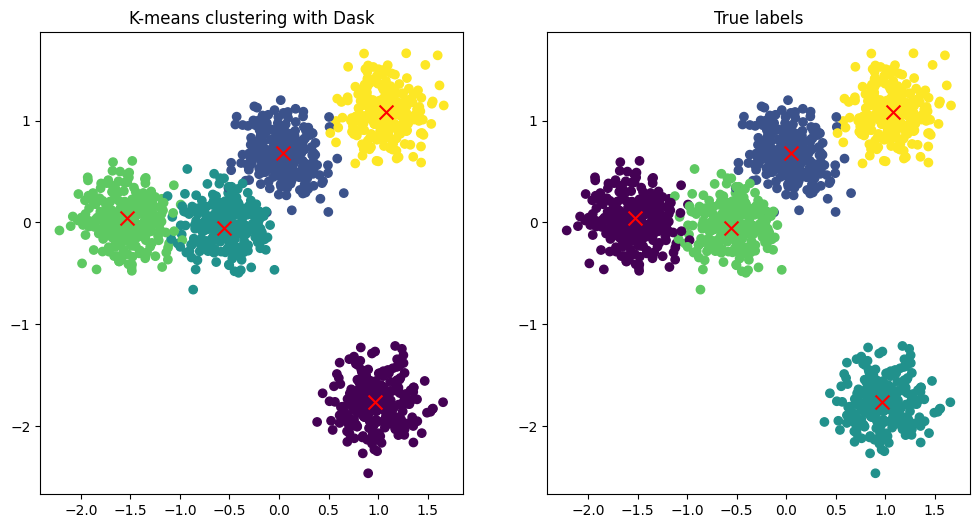

In [15]:
# Plotting a subset of the first 2 dim of the data 
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

subset = int(synt_normalized.shape[0]/10000)

# Kmeans labels plot
ax[0].scatter(synt_normalized[:subset, 0], synt_normalized[:subset, 1], c=synt_labels[:subset], cmap='viridis')
ax[0].scatter(synt_centroids[:, 0], synt_centroids[:, 1], c='red', marker='x', s=100)
ax[0].set_title('K-means clustering with Dask')

# True labels plot
ax[1].scatter(synt_normalized[:subset, 0], synt_normalized[:subset, 1], c=true_labels[:subset], cmap='viridis')
ax[1].scatter(synt_centroids[:, 0], synt_centroids[:, 1], c='red', marker='x', s=100)
ax[1].set_title('True labels')

plt.show()

In [16]:
%time dask_ml_kmeans = KMeans(n_clusters=centers).fit(synt_normalized)    
synt_centers = dask_ml_kmeans.cluster_centers_
synt_dask_labels = dask_ml_kmeans.labels_

/opt/daskenv1/lib/python3.12/site-packages/dask/base.py:1539: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


CPU times: user 825 ms, sys: 247 ms, total: 1.07 s
Wall time: 1min 52s


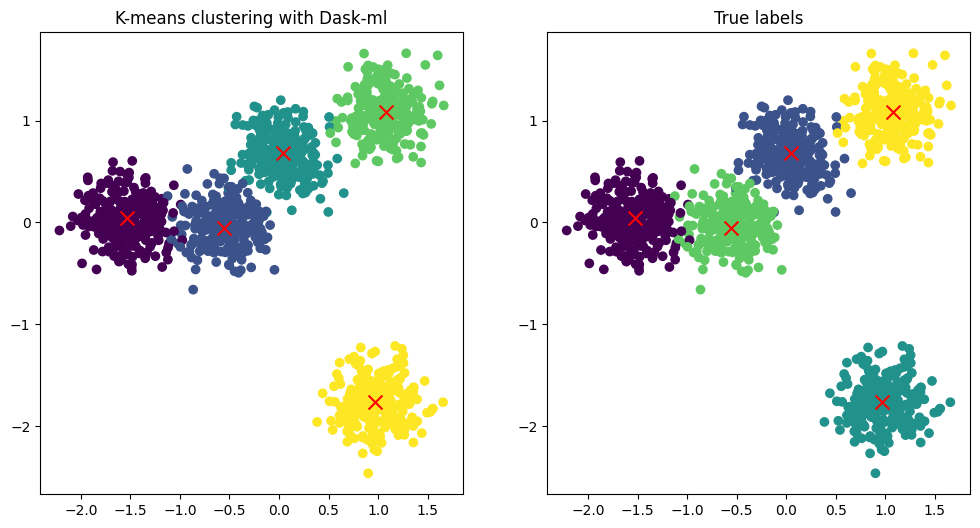

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# First plot: K-means labels clustering with Dask-ml
ax[0].scatter(synt_normalized[:subset, 0], synt_normalized[:subset, 1], c=synt_dask_labels[:subset], cmap='viridis')
ax[0].scatter(synt_centers[:, 0], synt_centers[:, 1], c='red', marker='x', s=100)
ax[0].set_title('K-means clustering with Dask-ml')

# Second plot: True labels
ax[1].scatter(synt_normalized[:subset, 0], synt_normalized[:subset, 1], c=true_labels[:subset], cmap='viridis')
ax[1].scatter(synt_centers[:, 0], synt_centers[:, 1], c='red', marker='x', s=100)
ax[1].set_title('True labels')

plt.show()

In [18]:
# Define a function to sort centroids for consistency
def sort_centroids(centroids):
    # Use np.lexsort to sort the centroids by all dimensions
    sorted_indices = np.lexsort(centroids.T)
    return centroids[sorted_indices]

# Sort both sets of centroids
sorted_synt_centers = sort_centroids(synt_centers)
sorted_synt_centroids = sort_centroids(synt_centroids)

# Check for equality with np.allclose
equality = np.allclose(sorted_synt_centers, sorted_synt_centroids, atol=1e-10)
print(f"Equality between Dask-ML KMeans and Custom KMeans: {equality}")

Equality between Dask-ML KMeans and Custom KMeans: True


We can observe that the results from the two algorithms, our custom implementation and the default Dask implementation, match with a precision of 1e-10.
Now that we have confirmed that our parallel K-Means algorithm is performing well, we are ready to apply it to the KDD Cup 1999 dataset.

In [19]:
#here we will close the cluster because for the benchmarking we will need to create others cluster with differents configurations
# Shut down the Dask cluster, terminating all associated workers and releasing resources.
cluster.close()

# Close the connection between the Dask client and the cluster to ensure no further communication.
client.close()

## 3) Dataset

### KDD Cup 1999 dataset

The KDD Cup 1999 dataset was developed for the 1999 KDD Cup competition to advance the field of network intrusion detection. It offers a comprehensive dataset designed to test the identification of network intrusions and anomalies. The competition required participants to create a predictive model that can effectively differentiate between "bad" connections, which indicate intrusions or attacks, and "good" connections, representing normal network activity.

Key Features:
- Size: The dataset consists of approximately 5 million records divided in training and testing sets
- Dimensionality :It contains 42 features describing network traffic, including attributes such as duration, protocol type, service, and various flags. These features help in identifying normal and malicious activity 
- Classes: The data is labeled with one of 24 different attack types or as "normal," making it a multi-class classification problem. The attacks are categorized into **four main categories**: DoS (Denial of Service), R2L (Remote to Local), U2R (User to Root), and Probe.


**Technical comments:**
- We loaded the dataset on the scheduler VM through a pandas dataframe then created a (eventually subsetted) numpy array version to create the dask array for the computation. 
- This approach required a careful management of the objects, hence the releasing of unused objects to free memory. 
- The dataset was normalized before the clustering.
- The dataset was sampled to 50%,80%,100% of the original size to explore more worker configurations during the benchmark.
- The dataset kmeans clustering itself takes little time with 50%, 80% and 100% of the dataset, so the visualization of the performance report is not ideal in any of those cases as the computation is too fast.Also for these reason we decided to show the performances report for the syntetic dataset in the previous paragraph.

### K-means|| benchmarking on KDD Cup 1999

**Benchmarking function:**
here we declare the function that will be used to benchmark the custom KMeans implementation and the Dask-ML KMeans implementation:
1. The function takes as input the data, number of workers, threads per worker, memory limit, chunks, and number of runs for both algorithms.
2. The function initalizes a cluster with the specified number of workers, threads per worker, memory limit.
3. Then it imports the data as a Dask array and normalizes it using the StandardScaler. We carefully delete unnecessary variables to avoid memory leaks as we tested configurations with a large number of workers and decided to use all the VMs available for the workers too.
4. It then benchmarks the custom KMeans implementation and the Dask-ML KMeans implementation for the specified number of runs and saves the mean and standard deviation of the runtimes.

**Technical choices:**
1. We use the SSHCluster to deploy the Dask cluster on the VMs dinamically at each iteration of the benchmarking function.
    - This is a good choice because we can easily scale the number of workers and threads per worker by changing the configurations in the worker_configs list.
    - Also, we make sure to close the client and cluster at the end of each iteration to avoid memory leaks in other iterations.
2. We import the data from an existing numpy array and use the StandardScaler to normalize the data.
    - This has the advantage to simplify the benchmarking cicle and avoid rechunking data so that we only track time of kmeans clustering and make sure not to pass other operations in out dask arrays.
    - The big disadvantage is that we have to keep in memory the KDDCUP99 data numpy array (in our scheduler) so we are a bit limited in the benchmarking configurations choice, hence the decision to run 80% of the dataset and keep the cicle as is because of time costraints.

As we lacked time we did not do a full proper grid search along the configuration and chunk axis but we tested some chosen configurations with a fixed chunk size, and then did the opposite, testing only the best configuration with different chunk sizes.

**here we putted raw cells just to show all the code in a chronological order for the presentation with the comment and showing the plots, but we decided to run it in "benchmark.ipynb" and "report_finale.ipynb" because it was more convenient to run it on a separate file rather than running the entire Jupyter notebook from the beginning.**

**benchmarking for cluster configurations**

**benchmarking for chunks**

## Results


**this cell can be run to concatenate more than one benchmark file** (caution with doing it more than once)

**here we have the plots for the benchmarks clusters configurations**

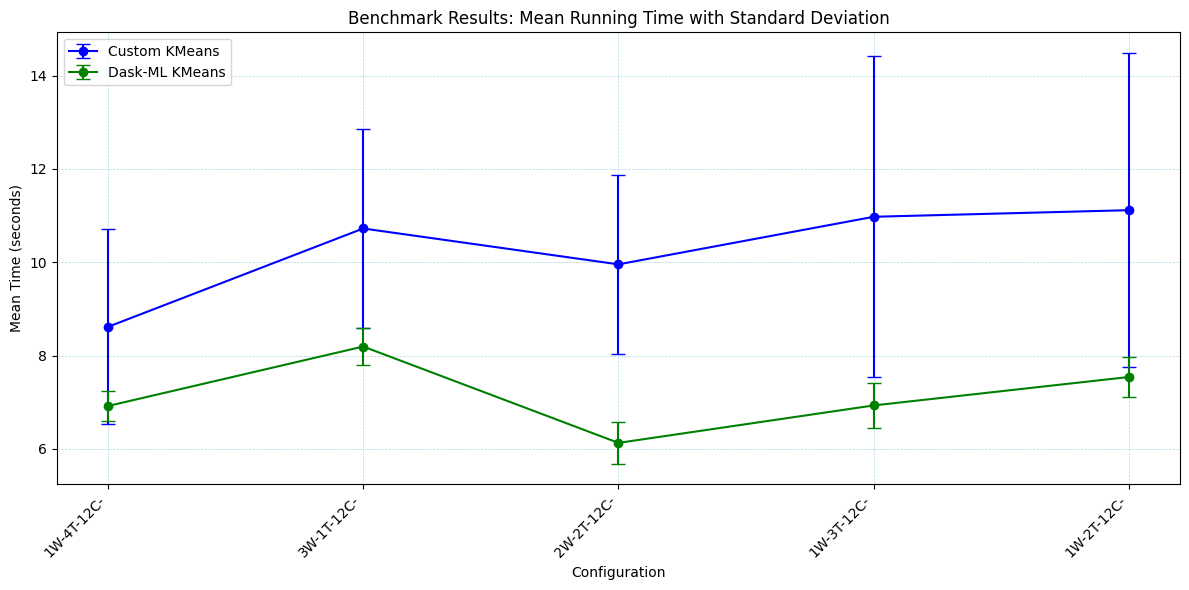

In [20]:

# Load benchmark results from file
results_df = pd.read_pickle('benchmark_results_cluster_config_80PERC_14runs.pickle')

# Prepare data for plotting
configs = [f"{row['workers']}W-{row['threads']}T-{row['chunks']}C-" for _, row in results_df.iterrows()]
custom_means = results_df['custom_kmeans_mean_time']
custom_stds = results_df['custom_kmeans_std_time']
dask_ml_means = results_df['dask_ml_mean_time']
dask_ml_stds = results_df['dask_ml_std_time']

# Create a plot
plt.figure(figsize=(12, 6))
x = range(len(configs))

# Plot Custom KMeans times with lines connecting points
plt.errorbar(x, custom_means, yerr=custom_stds, fmt='o-', label='Custom KMeans', capsize=5, color='blue')

# Plot Dask-ML KMeans times with lines connecting points
plt.errorbar(x, dask_ml_means, yerr=dask_ml_stds, fmt='o-', label='Dask-ML KMeans', capsize=5, color='green')

# Customize the plot
plt.xticks(x, configs, rotation=45, ha='right')
plt.xlabel('Configuration')
plt.ylabel('Mean Time (seconds)')
plt.title('Benchmark Results: Mean Running Time with Standard Deviation')

# Add a light blue grid
plt.grid(True, linestyle='--', linewidth=0.5, color='lightblue')

# Add a legend
plt.legend()

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

**here we have the plots for the benchmarks chunks sizes**

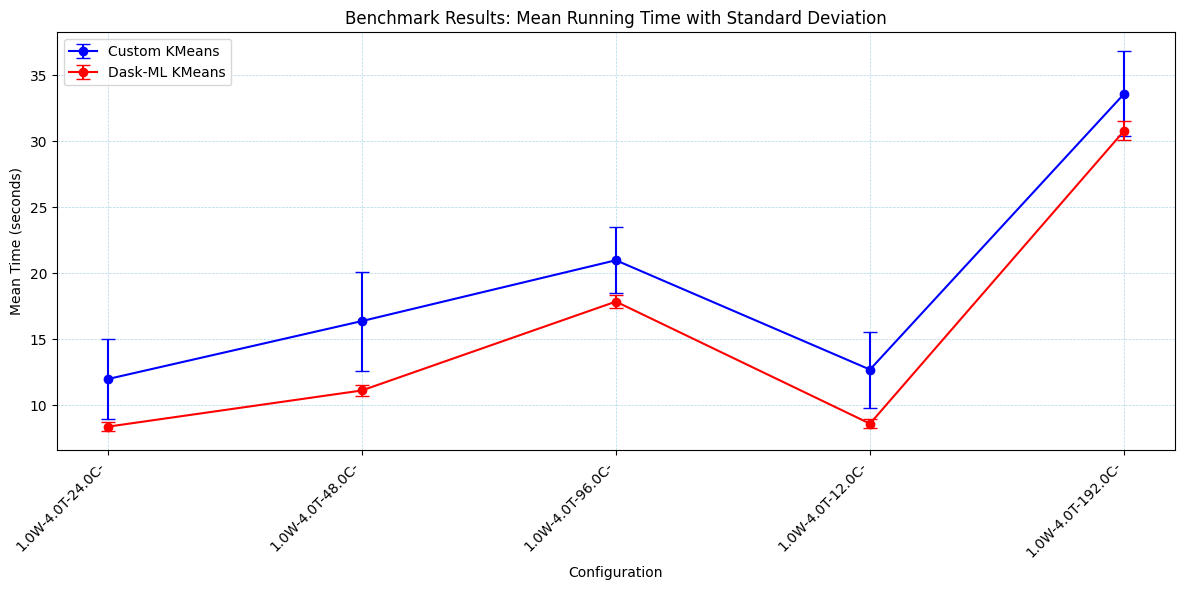

In [21]:

# Load benchmark results from file
results_df = pd.read_pickle('benchmark_results_cluster_all_dataset_chunks.pickle')

# Prepare data for plotting
configs = [f"{row['workers']}W-{row['threads']}T-{row['chunks']}C-" for _, row in results_df.iterrows()]
custom_means = results_df['custom_kmeans_mean_time']
custom_stds = results_df['custom_kmeans_std_time']
dask_ml_means = results_df['dask_ml_mean_time']
dask_ml_stds = results_df['dask_ml_std_time']

# Create a plot
plt.figure(figsize=(12, 6))
x = range(len(configs))

# Plot Custom KMeans times with lines connecting points
plt.errorbar(x, custom_means, yerr=custom_stds, fmt='o-', label='Custom KMeans', capsize=5, color='blue')

# Plot Dask-ML KMeans times with lines connecting points
plt.errorbar(x, dask_ml_means, yerr=dask_ml_stds, fmt='o-', label='Dask-ML KMeans', capsize=5, color='red')

# Customize the plot
plt.xticks(x, configs, rotation=45, ha='right')
plt.xlabel('Configuration')
plt.ylabel('Mean Time (seconds)')
plt.title('Benchmark Results: Mean Running Time with Standard Deviation')

# Add a light blue grid
plt.grid(True, linestyle='--', linewidth=0.5, color='lightblue')

# Add a legend
plt.legend()

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

**Comments**:\
As we can see the two benchmark routines return a clear winner: the configuration using 1 worker per VM, 4 threads with chunk size equal to 12
is clearly better than the other ones, we can see that the same configuration with chunk size 24 is not that different as the chunks are still sized so that
their computation takes significantly longer that the scheduler task managing overhead.

### Dask's Dashboard Analysis


So we chose the best configuration for the set up cluster to do a single run for both the worst chunk size of 192 and the best of 12 to compare
the performance report of both. \
Here below are the already saved files from the file report_finale.ipynb

***IMPORTANT***: to visualize the performance report you can and may need re-run the cell here below\
As the IRpython display may not properly save and visualize the report, you can use the following code to visualize the report quickly.
This choice albeit not very practical has been chosen to visualize an interactive performance report to the fullest without resorting to poor formatted images

In [22]:
# we import the needed library directly in this cell so that one can safely run only this cell if needed
from IPython.display import IFrame
# Display the HTML report in Jupyter
report_filename = "dask_performance_report_good_12chunks_7gb.html" # you can select different files to see different reports
IFrame(src=report_filename, width=1280, height=720)

In [23]:
# we import the needed library directly in this cell so that one can safely run only this cell if needed
from IPython.display import IFrame
# Display the HTML report in Jupyter
report_filename = "dask_performance_report_good_192chunks_7gb.html" # you can select different files to see different reports
IFrame(src=report_filename, width=1280, height=720)


In [24]:
#we will discuss these results extensively in the presentation